# How to pass graph state to tools

Sometimes we need to pass in agent state to our tools. This type of stateful tools is useful when a tool's output is affected by past agent steps (e.g. if you're using a sub-agent as a tool, and want to pass the message history in to the sub-agent), or when a tool's input needs to be validated given context from past agent steps. 

In this guide we'll demonstrate how to create tools that take agent state as input.

This is a special case of [passing runtime arguments to tools](https://python.langchain.com/v0.2/docs/how_to/tool_runtime/), which you can learn about in the LangChain docs.

## Setup

First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/openai
```

Next, we need to set API keys for OpenAI (the LLM we will use)

```bash
export OPENAI_API_KEY=your-api-key
```

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Defining the tools

We'll want our tool to take graph state as an input, but we don't want the model to try to generate this input when calling the tool. In order to pass runtime values to our tools, we are going to wrap them in a factory function 

In [64]:
import { tool } from '@langchain/core/tools';
import { z } from 'zod';
import { Document } from '@langchain/core/documents';
import { ChatOpenAI } from '@langchain/openai'
import { ToolMessage } from '@langchain/core/messages';
import { BaseMessage } from '@langchain/core/messages';

let model = new ChatOpenAI({ model: "gpt-4o" })

const cite = z.object({
  indexes: z.array(z.number()).describe("Return the index(es) of the documents that justify the claim"),
});

function generateTools(messages: BaseMessage[]) {
  const getContext = tool(() => {    
      const docs: Document[] = [
          {
              pageContent: "FooBar company just raised 1 Billion dollars!",
              metadata: { source: "twitter" }
          },
          {
              pageContent: "FooBar company is now only hiring AI's",
              metadata: { source: "twitter" }
          },
          {
              pageContent: "FooBar company was founded in 2019",
              metadata: { source: "wikipedia" }
          },
          {
              pageContent: "FooBar company makes friendly robots",
              metadata: { source: "wikipedia" }
          }
      ];
      // Join the page content of all documents with "\n\n"
      const joinedContent: string = docs.map(doc => doc.pageContent).join("\n\n");
  
      return [ joinedContent, docs ];
  }, {
      name: 'get_context',
      description: 'Get context on the question',
      schema: z.object({
          question: z.string().describe("The user question"),
      }),
      responseFormat: "content_and_artifact"
  })
  
  const citeContextSources = tool(async (input) => {    
    const docs: Document[] = [];
  
    // We get the potentially cited docs from past ToolMessages in our state.
    for (const msg of messages) {
        if ((msg as ToolMessage).name === "get_context") {
            console.log(msg);
            docs.push(...(msg as ToolMessage).artifact);
        }
    }
  
    // Define the Cite interface
    const structuredModel = model.withStructuredOutput(cite);
  
    // Create the system prompt and context
    const system: string = `Which of the following documents best justifies the claim:\n\n${input.claim}`;
    const context: string = docs.map((doc, i) => `Document ${i}:\n${doc.pageContent}`).join("\n\n");
  
    // Invoke the structured model to get the citation
    const citation = await structuredModel.invoke([["system", system], ["human", context]]);
  
    // Get the cited documents based on the indexes returned
    const citedDocs: Document[] = citation.indexes.map(i => docs[i]);
  
    // Extract the sources from the cited documents
    const sources: string = citedDocs.map(doc => doc.metadata.source).join(", ");
  
    // Return the sources and cited documents
    return [ sources, citedDocs ];
  
  }, {
    name: 'cite_context_sources',
    description: 'Cite which source a claim was based on.',
    schema: z.object({
        claim: z.string().describe("The claim that was made."),
    }),
    responseFormat: "content_and_artifact"
  })

  return [getContext, citeContextSources];
}

If we look at the tool call schema, which is what is passed to the model for tool-calling, only `claim` is being passed:

In [65]:
import { zodToJsonSchema } from "zod-to-json-schema";

let tools = generateTools([]);

console.log(zodToJsonSchema(tools[1].schema));

{
  type: 'object',
  properties: {
    claim: { type: 'string', description: 'The claim that was made.' }
  },
  required: [ 'claim' ],
  additionalProperties: false,
  '$schema': 'http://json-schema.org/draft-07/schema#'
}


## Define the agent state

For this example, the state we will track will just be a list of messages.

In [66]:
import { Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const AgentState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
      reducer: (x, y) => x.concat(y),
  }),
});

## Define the nodes

We now need to define a few different nodes in our graph.

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.

1. After the agent is called, we should either invoke the tool node or finish.
2. After the tool node have been invoked, it should always go back to the agent to decide what to do next

In [67]:
import { END, START, StateGraph, MemorySaver } from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";


const routeMessage = (state: typeof AgentState.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // If no tools are called, we can finish (respond to the user)
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // Otherwise if there is, we continue and call the tools
  return "tools";
};

const callModel = async (
  state: typeof AgentState.State,
) => {
  // For versions of @langchain/core < 0.2.3, you must call `.stream()`
  // and aggregate the message from chunks instead of calling `.invoke()`.
  const { messages } = state;
  const tools = generateTools(messages);
  const modelWithTools = model.bindTools(tools);
  const responseMessage = await modelWithTools.invoke(messages);
  return { messages: [responseMessage] };
};

const toolNodeWithGraphState = async (
  state: typeof AgentState.State,
) => {
  // For versions of @langchain/core < 0.2.3, you must call `.stream()`
  // and aggregate the message from chunks instead of calling `.invoke()`.
  const { messages } = state;
  const tools = generateTools(messages);
  const toolNodeWithConfig = new ToolNode(tools);
  return toolNodeWithConfig.invoke(state);
};

const workflow = new StateGraph(AgentState)
  .addNode("agent", callModel)
  .addNode("tools", toolNodeWithGraphState)
  .addEdge(START, "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const memory = new MemorySaver();

const graph = workflow.compile({ checkpointer: memory });

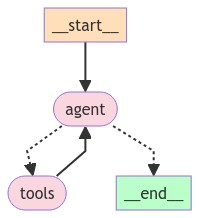

In [68]:
import * as tslab from "tslab";

const graphViz = graph.getGraph();
const image = await graphViz.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Use it!

Let's use our graph now!

In [69]:
let inputs = { messages: [{ role: "user", content: "what's the latest single news item about FooBar?" }] };
let config = {"configurable": {"thread_id": "1"}};
let stream = await graph.stream(inputs, {
  ...config
});

for await (
  const chunk of stream
) {
  for (const [node, values] of Object.entries(chunk)) {
    console.log(`Output from node: ${node}`);
    console.log("---");
    console.log(values);
    console.log("\n====\n");
  }
}

Output from node: agent
---
{
  messages: [
    AIMessage {
      "id": "chatcmpl-A21xZit0BvWyJmQzk10Vhc02KRjEf",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_ulYSy9h9fOdgPpDB5XphVCCD",
            "type": "function",
            "function": "[Object]"
          }
        ]
      },
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 18,
          "promptTokens": 90,
          "totalTokens": 108
        },
        "finish_reason": "tool_calls",
        "system_fingerprint": "fp_157b3831f5"
      },
      "tool_calls": [
        {
          "name": "get_context",
          "args": {
            "question": "latest news about FooBar"
          },
          "type": "tool_call",
          "id": "call_ulYSy9h9fOdgPpDB5XphVCCD"
        }
      ],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 90,
        "output_tokens": 18,
        "total_tokens": 108
      }
  

Let's now verify it can properly cite where it got the information from:

In [70]:
inputs = { messages: [{ role: "user", content: "where did you get this information?" }] };
stream = await graph.stream(inputs, {
  ...config
});

for await (
  const chunk of stream
) {
  for (const [node, values] of Object.entries(chunk)) {
    console.log(`Output from node: ${node}`);
    console.log("---");
    console.log(values);
    console.log("\n====\n");
  }
}

Output from node: agent
---
{
  messages: [
    AIMessage {
      "id": "chatcmpl-A21xjjRnPQVQtgGsyayQzLpsKnRpW",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_XAy5OkV8bxxlEILsI7I7kEpN",
            "type": "function",
            "function": "[Object]"
          }
        ]
      },
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 32,
          "promptTokens": 184,
          "totalTokens": 216
        },
        "finish_reason": "tool_calls",
        "system_fingerprint": "fp_157b3831f5"
      },
      "tool_calls": [
        {
          "name": "cite_context_sources",
          "args": {
            "claim": "The latest news about FooBar is that the company just raised 1 Billion dollars!"
          },
          "type": "tool_call",
          "id": "call_XAy5OkV8bxxlEILsI7I7kEpN"
        }
      ],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 184,
    

As we can see the agent is able to properly cite that the information came from Twitter!